# Model training using Mcfly AutoML

## Loading the dataset

In [63]:
import os
import sys
import json
# import mlflow
import warnings
import numpy as np
import pandas as pd
from datetime import timedelta
from sktime.datatypes import convert_to
from timeit import default_timer as timer
from sktime.datasets import load_from_tsfile
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sktime.datasets import load_from_tsfile_to_dataframe
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples
from tensorflow.keras.metrics import AUC
from plot_keras_history import show_history, plot_history

warnings.filterwarnings('ignore')
np.random.seed(42)

In [14]:
X, y = load_from_tsfile("data/alfa-uav-fault-detection.ts", return_y=True, return_data_type="numpy3D")

X.shape, y.shape

((2792, 17, 40), (2792,))

In [15]:
X = np.swapaxes(X, 1, 2)
X.shape

(2792, 40, 17)

In [16]:
ohe = OneHotEncoder()

y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
y.shape

(2792, 2)

In [18]:
X, y = shuffle(X, y, random_state=42)
X.shape, y.shape

((2792, 40, 17), (2792, 2))

### Splitting into training, validation and test datasets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, random_state=42, 
                                                    shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.20, random_state=42, 
                                                  shuffle=True, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1786, 40, 17) (447, 40, 17) (559, 40, 17)
(1786, 2) (447, 2) (559, 2)


## Model training

### Calculating class weights

In [42]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y, axis=1)),
    y = np.argmax(y, axis=1)                                                    
)

class_weights = dict(zip(np.unique(np.argmax(y, axis=1)), class_weights))
class_weights

{0: 0.5377503852080123, 1: 7.122448979591836}

### Training classification models

In [43]:
%%time

file_name = f"model-comparison-20220808.json"
output_file = os.path.join("data/models", file_name)
model_path = os.path.join("data/models")

pr_auc = AUC(
    curve="PR",
    name="pr_auc",
)

models = generate_models(
    X_train.shape, 
    y_train.shape[1],
    number_of_models=3,
    model_types=['CNN', 'ResNet', 'InceptionTime'],
    metrics=[pr_auc]
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=X_train.shape[0],
    class_weight=class_weights
)

Set maximum kernel size for InceptionTime models to number of timesteps.
Generated models will be trained on subset of the data (subset size: 1786).
Training model 0 CNN
Epoch 1/30
90/90 [==============================] - 6s 36ms/step - loss: 1.5878 - pr_auc: 0.6675 - val_loss: 2.0570 - val_pr_auc: 0.4055
Epoch 2/30
90/90 [==============================] - 2s 25ms/step - loss: 1.4203 - pr_auc: 0.7953 - val_loss: 1.8238 - val_pr_auc: 0.4837
Epoch 3/30
90/90 [==============================] - 2s 24ms/step - loss: 1.3231 - pr_auc: 0.8721 - val_loss: 1.7264 - val_pr_auc: 0.5153
Epoch 4/30
90/90 [==============================] - 2s 25ms/step - loss: 1.2379 - pr_auc: 0.9291 - val_loss: 1.6597 - val_pr_auc: 0.5228
Epoch 5/30
90/90 [==============================] - 2s 25ms/step - loss: 1.1633 - pr_auc: 0.9647 - val_loss: 1.5709 - val_pr_auc: 0.6078
Epoch 6/30
90/90 [==============================] - 2s 25ms/step - loss: 1.0994 - pr_auc: 0.9649 - val_loss: 1.4245 - val_pr_auc: 0.7968
Epoch 7/

90/90 [==============================] - 3s 31ms/step - loss: 1.5081e-04 - pr_auc: 1.0000 - val_loss: 3.1383e-04 - val_pr_auc: 1.0000
Epoch 20/30
90/90 [==============================] - 3s 31ms/step - loss: 1.3553e-04 - pr_auc: 1.0000 - val_loss: 2.7695e-04 - val_pr_auc: 1.0000
Epoch 21/30
90/90 [==============================] - 3s 31ms/step - loss: 1.2240e-04 - pr_auc: 1.0000 - val_loss: 2.4531e-04 - val_pr_auc: 1.0000
Epoch 22/30
90/90 [==============================] - 3s 31ms/step - loss: 1.1103e-04 - pr_auc: 1.0000 - val_loss: 2.1845e-04 - val_pr_auc: 1.0000
Epoch 23/30
90/90 [==============================] - 3s 31ms/step - loss: 1.0112e-04 - pr_auc: 1.0000 - val_loss: 1.9575e-04 - val_pr_auc: 1.0000
Epoch 24/30
90/90 [==============================] - 3s 31ms/step - loss: 9.2424e-05 - pr_auc: 1.0000 - val_loss: 1.7598e-04 - val_pr_auc: 1.0000
Epoch 25/30
90/90 [==============================] - 3s 31ms/step - loss: 8.4739e-05 - pr_auc: 1.0000 - val_loss: 1.5889e-04 - val_pr_au

In [46]:
best_model_index = np.argmax(val_metrics["pr_auc"])
best_model, best_params, best_model_type = models[best_model_index]

print("Best model type:", best_model_type)

Best model type: InceptionTime


### Plotting training history

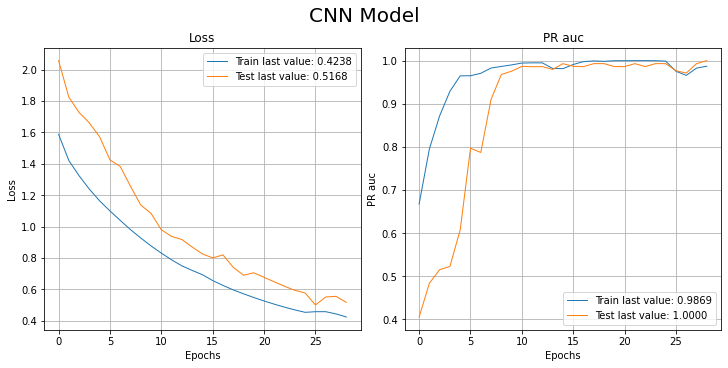

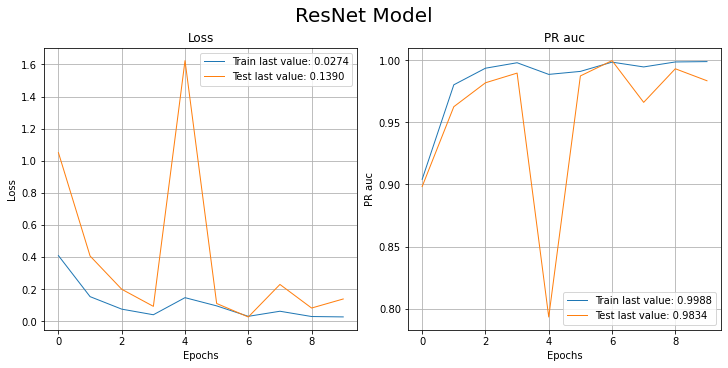

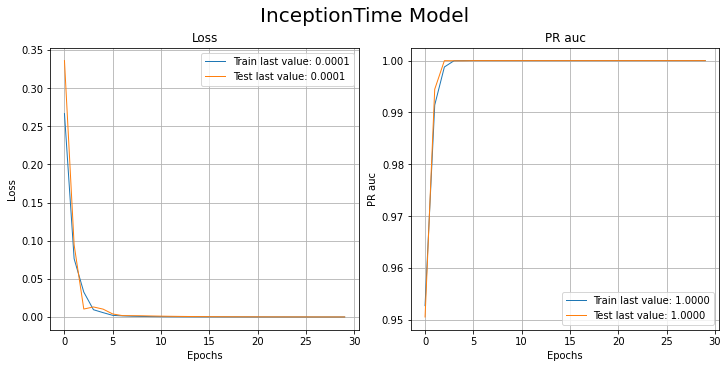

In [61]:
model_types = ['CNN', 'ResNet', 'InceptionTime']

for i in range(len(model_types)):
    show_history(histories=history[i], title=f"{model_types[i]} Model")

### Evaluating the best model

In [67]:
y_pred = best_model.predict(X_test, batch_size=1)

559/559 [==============================] - 3s 6ms/step


In [68]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       1.00      1.00      1.00        39

    accuracy                           1.00       559
   macro avg       1.00      1.00      1.00       559
weighted avg       1.00      1.00      1.00       559

